In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Load the data

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Normalize the Input

In [4]:
train_images = train_images / 255.0

test_images = test_images / 255.0

In [5]:
train_images = train_images.reshape(-1, 28,28, 1)
test_images = test_images.reshape(-1, 28,28, 1)

In [6]:
train_tfds = (tf.data.Dataset.from_tensor_slices((
            tf.cast(train_images, tf.float32),
            tf.cast(train_labels, tf.uint8))))

test_tfds = (tf.data.Dataset.from_tensor_slices((
            tf.cast(test_images, tf.float32),
            tf.cast(test_labels, tf.uint8))))

2021-11-28 17:51:29.659190: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def preprocessing(ds):
    ds = ds.map(lambda feature, label: (feature, tf.one_hot(label, 10)))
    ds = ds.cache()
    ds = ds.shuffle(500)
    ds = ds.batch(50)
    ds = ds.prefetch(2)
    return ds

In [8]:
train_ds = train_tfds.apply(preprocessing)
test_ds = test_tfds.apply(preprocessing)

In [11]:
class MyModel(tf.keras.Model):
    def __init__(self, loss_function, optimizer= None):
        super(MyModel, self).__init__()

        self.conv_layer1 = tf.keras.layers.Conv2D(filters=15, activation='linear', 
                                       kernel_size=(3,3),  
                                       padding="same")
        # self.leakyRelu = tf.keras.layers.LeakyReLU(alpha=0.1)

        self.max_pooling1 = tf.keras.layers.MaxPool2D((2,2), padding='same')

        self.conv_layer2 = tf.keras.layers.Conv2D(filters=32, activation='linear',
                                       kernel_size=(3,3),
                                       strides = (2,2),
                                       padding="valid")

        self.global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()

        self.output_layer = tf.keras.layers.Dense(10, activation='softmax')

        self.loss_function = loss_function
        self.optimizer = optimizer

    
    def call(self, inputs):
        output_conv_layer1 = self.conv_layer1(inputs)
        # output_leaky_relu = self.leakyRelu(output_conv_layer1)
        output_maxpooling = self.max_pooling1(output_conv_layer1)
        output_conv_layer2 = self.conv_layer2(output_maxpooling)
        output_global_avg_pooling = self.global_avg_pooling(output_conv_layer2)
        output_conv_layer2 = self.output_layer(output_global_avg_pooling)

        return output_conv_layer2
        
    def train(self, input, target):
        with tf.GradientTape() as tape:
            prediction = self(input)
            loss = self.loss_function(prediction, target)
        gradients = tape.gradient(loss, self.trainable_variables)
        if self.optimizer:
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        same_prediction = np.round(target,0) == np.round(prediction, 0)
        accuracy = np.mean(same_prediction)
        return loss, accuracy

    def test(self, test_data):
        """Calculate the mean loss and accuracy of the model over all elements
        of test_data.

        :param test_data: model is evaulated for test_data
        :type test_data: tensorflow 'Dataset'
        :return: mean loss and mean accuracy for all datapoints
        :rtype: tuple of two floats
        """
        # aggregator lists for tracking the loss and accuracy
        test_accuracy_agg = []
        test_loss_agg = []
        # iterate over all input-target pairs in test_data
        for input, target in test_data:
            prediction = self(input)
            loss = self.loss_function(target, prediction)
            same_prediction = np.round(target,0) == np.round(prediction, 0)
            accuracy = np.mean(same_prediction)
            # add loss and accuracy to aggregators
            test_loss_agg.append(loss.numpy())
            test_accuracy_agg.append(np.mean(accuracy))
        # calculate mean loss and accuracy
        test_loss = tf.reduce_mean(test_loss_agg)
        test_accuracy = tf.reduce_mean(test_accuracy_agg)
        return test_loss, test_accuracy

In [12]:
tf.keras.backend.clear_session()

# Setting Hyperparameters
EPOCHS = 10
LEARNING_RATE = 0.1

# Initialize the loss-function
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(LEARNING_RATE)
# Initialize the model
model = MyModel(cross_entropy_loss, optimizer)

# Initialize lists for tracking loss and accuracy
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Testing models performance before training starts.
# Test-Dataset
test_loss, test_accuracy = model.test(test_ds)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
# Train-Dataset
train_loss, train_accuracy = model.test(test_ds)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# Training for EPOCHS.
for epoch in range(EPOCHS+1):
    print(f'Epoch {str(epoch)} starting with test-accuracy of {np.round(test_accuracies[-1],3)}')
    epoch_loss_agg = []
    epoch_accuracy_agg = []
    for input, target in train_ds:
        train_loss, train_accuracy = model.train(input, target)
        epoch_loss_agg.append(train_loss)
        epoch_accuracy_agg.append(train_accuracy)

    # track training loss and accuracy
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    train_accuracies.append(tf.reduce_mean(epoch_accuracy_agg))
    # track loss and accuracy for test-dataset
    test_loss, test_accuracy = model.test(test_ds)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

2021-11-28 17:52:37.316153: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 0 starting with test-accuracy of 0.9
Epoch 1 starting with test-accuracy of 0.82
Epoch 2 starting with test-accuracy of 0.82
Epoch 3 starting with test-accuracy of 0.82
Epoch 4 starting with test-accuracy of 0.82
Epoch 5 starting with test-accuracy of 0.82
Epoch 6 starting with test-accuracy of 0.82
Epoch 7 starting with test-accuracy of 0.82
Epoch 8 starting with test-accuracy of 0.82
Epoch 9 starting with test-accuracy of 0.82


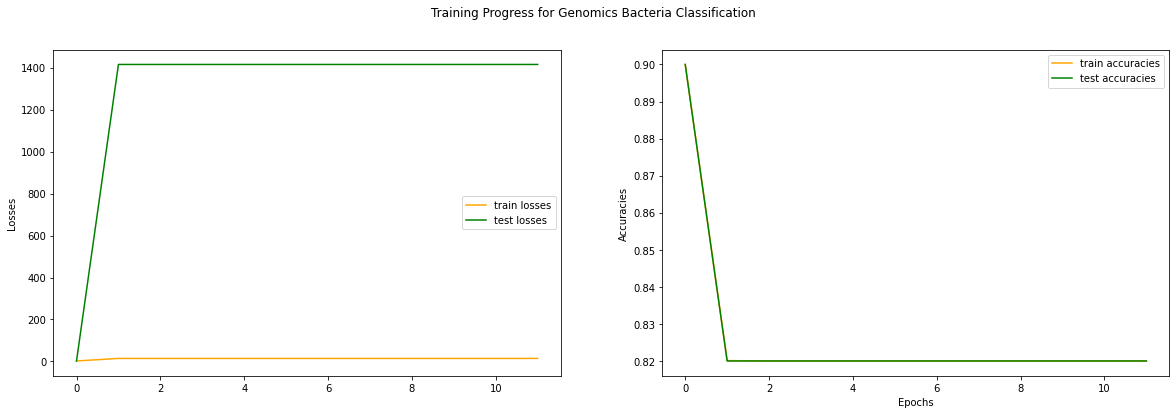

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 6)

fig.suptitle('Training Progress for Genomics Bacteria Classification')
axs[0].plot(train_losses, color='orange', label='train losses')
axs[0].plot(test_losses, color='green', label='test losses')
axs[0].set(ylabel='Losses')
axs[0].legend()
axs[1].plot(train_accuracies, color='orange', label='train accuracies')
axs[1].plot(test_accuracies, color='green', label='test accuracies')

axs[1].set(xlabel='Epochs', ylabel='Accuracies')
axs[1].legend()